In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import osyris

import disctools
import disctools.disc_cuts
import disctools.datacube
import disctools.contour_integrals
import disctools.datacube_utils
import disctools.disc_analysis
import disctools.intersections
%matplotlib notebook

In [3]:
output_number=0
data = osyris.Dataset(output_number, path=".").load()

Processing 128 files in ./output_01616
 10% : read     171136 cells,         17 particles
 20% : read     486595 cells,        127 particles
 30% : read     679371 cells,        292 particles
 40% : read     742280 cells,        343 particles
 50% : read     796120 cells,       2147 particles
 60% : read     873537 cells,       2155 particles
 70% : read     946010 cells,      11560 particles
 80% : read    1004717 cells,      12491 particles
 90% : read    1856884 cells,      13018 particles
Loaded: 3095240 cells, 13309 particles.


In [7]:
data["hydro"]["rv"]=data["hydro"]["velocity"]*data["amr"]["position"]

In [10]:
data=osyris.extract_box(data,dx=40*osyris.units("au"), dy=40*osyris.units("au"), dz=40*osyris.units("au"), origin=data["sink"]["position"])

In [13]:
data["hydro"]["beta"]=data["hydro"]["thermal_pressure"]/(2*(data["hydro"]["B_field"].dot(data["hydro"]["B_field"])))

In [14]:
data["hydro"]["b2"]=data["hydro"]["B_field"].dot(data["hydro"]["B_field"])

In [17]:
data["amr"]["position"]=data["amr"]["position"]-data["sink"]["position"]

In [18]:
imp.reload(disctools.datacube)

<module 'disctools.datacube' from '/Users/fra/Code/disctools/disctools/datacube.py'>

In [19]:
cube=disctools.datacube.osyris_make_cube(data)

In [20]:
positionArray=np.stack((data["amr"]["position"].x.values,data["amr"]["position"].y.values,data["amr"]["position"].z.values),axis=-1)

In [21]:
imap=disctools.datacube.make_mapping(positionArray,data["amr"]["level"].values,cube)

building amr level 13
building amr level 14
building amr level 15
building amr level 16


IndexError: index 162 is out of bounds for axis 1 with size 162

In [ ]:
density=disctools.datacube.fill_array_scalar(data["hydro"]["density"].values,imap)
pressure=disctools.datacube.fill_array_scalar(data["hydro"]["thermal_pressure"].values,imap)
cs=np.sqrt(pressure/density)

In [24]:
beta=disctools.datacube.fill_array_scalar(data["hydro"]["beta"].values,imap)

In [27]:
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)

In [28]:
angularMom=disctools.disc_analysis.angular_momentum(velocity,density,1.0,cube)

In [29]:
from numba import njit, prange, stencil

In [30]:
@njit
def cut_mom_in(momentum):
    absmom=np.abs(momentum[:,:,:,2])
    return absmom>0.005*np.max(absmom)

In [31]:
cut_Dens=disctools.disc_cuts.make_cut_array(density,cut_mom_in,angularMom)
cut_beta=disctools.disc_cuts.make_cut_array(beta,cut_mom_in,angularMom)

In [32]:
ind = np.unravel_index(np.argmax(density,axis=None),density.shape)

(82, 81, 81)

In [35]:
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

<IPython.core.display.Javascript object>


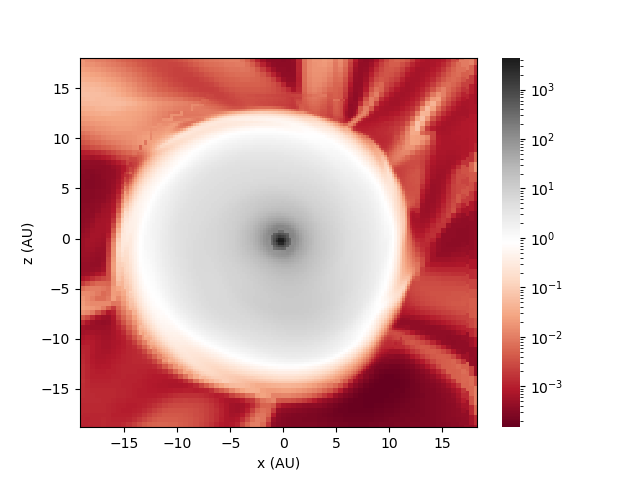

ValueError: 
$ eta _\mathrm{plasma} $
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

In [41]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], (beta[5:-5,5:-5,81]),norm=colors.LogNorm(), cmap='RdGy')
cbar=fig.colorbar(c, ax=ax).set_label("$ \beta _\mathrm{plasma} $")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")
plt.tight_layout()

In [42]:
angularMom.shape

(164, 162, 162, 3)

<IPython.core.display.Javascript object>


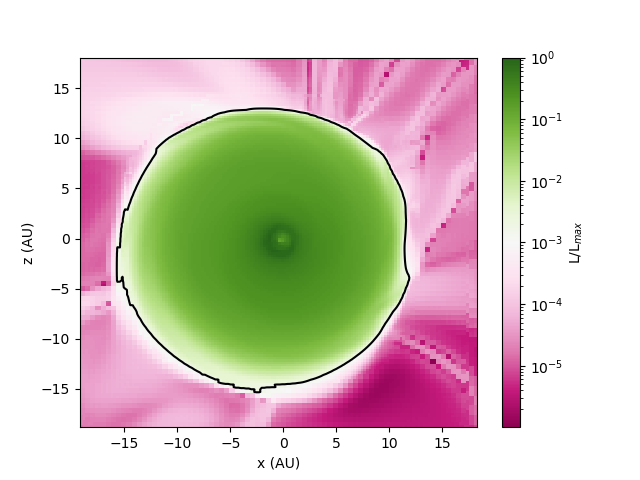

Text(0, 0.5, 'z (AU)')

In [43]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='PiYG')
cbar=fig.colorbar(c, ax=ax).set_label("L/L$_{max}$")
cont = ax.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


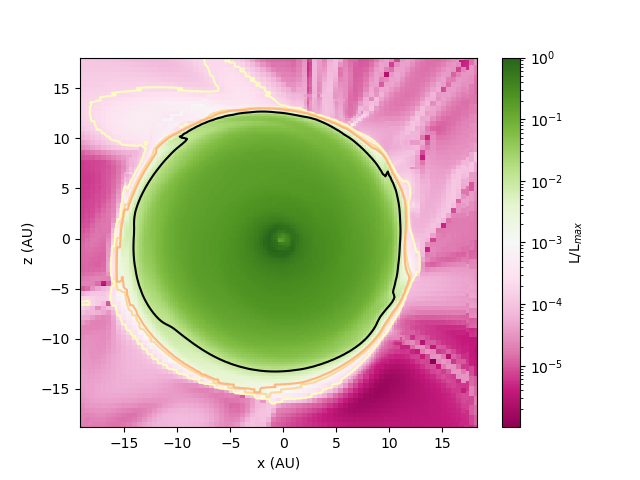

Text(0, 0.5, 'z (AU)')

In [44]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='PiYG')
cbar=fig.colorbar(c, ax=ax).set_label("L/L$_{max}$")
cont = ax.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.00001,0.00006,0.0001,0.0006],cmap="magma_r")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


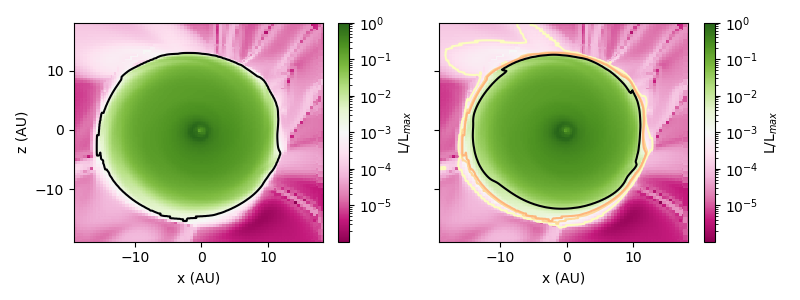

In [45]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 1]},sharey=True)
#ecc_plot.set_figheight(10)
#map_plot.set_aspect(1)
c = ax.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='PiYG')
cbar=fig.colorbar(c, ax=ax).set_label("L/L$_{max}$")
cont = ax.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.0001],cmap="magma")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

c = ax1.pcolormesh(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:],axis=-1)),norm=colors.LogNorm(), cmap='PiYG')
cbar=fig.colorbar(c, ax=ax1).set_label("L/L$_{max}$")
cont = ax1.contour(cube_au[5:-5,5:-5,81,0], cube_au[5:-5,5:-5,81,1], np.linalg.norm(angularMom[5:-5,5:-5,81,:],axis=-1)/np.max(np.linalg.norm(angularMom[:,:,81,:])), [0.00001,0.00006,0.0001,0.0006],cmap="magma_r")
#cbar.clim(vmax=cut_beta.max(), vmin=1./cut_beta.max())
ax1.set_xlabel("x (AU)")
plt.tight_layout()

In [46]:
totmom=disctools.disc_analysis.angular_momentum_sphere(velocity,density,1.0,cube)

In [47]:
#rot_V,rot_X=disctools.disc_analysis.make_vector_z_axis(totmom,velocity),disctools.disc_analysis.make_vector_z_axis(totmom,cube)

In [48]:
sink_pos=np.array((0.0,0.0,0.0))

In [49]:
sink_pos.reshape(1,3)

array([[0., 0., 0.]])

In [50]:
imp.reload(disctools.intersections)

<module 'disctools.intersections' from '/Users/fra/Code/disctools/disctools/intersections.py'>

In [51]:
sink_plane=disctools.intersections.Plane.plane_from_vector(totmom,sink_pos)

In [52]:
crossed_by_midplane=disctools.intersections.cells_intersected_plane_int(cube,np.min(data["amr"]["dx"].values),sink_plane)

In [53]:
cut_Dens_float=disctools.disc_cuts.make_outside_zeros(density,cut_mom_in,angularMom)

In [54]:
midplane_cut_dens=cut_Dens_float*crossed_by_midplane

<IPython.core.display.Javascript object>


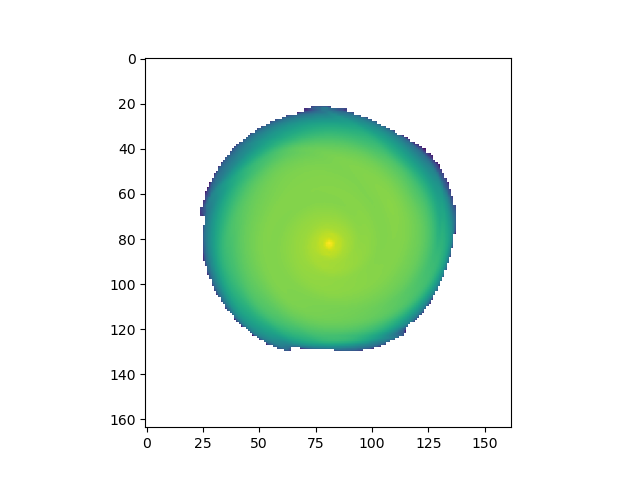

/var/folders/lr/w2rb22ks5v78l_gp4s5dz17h0000gn/T/ipykernel_5445/1213654535.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.sum((cut_Dens_float),axis=-1)))


In [55]:
plt.figure()
plt.imshow(np.log(np.sum((cut_Dens_float),axis=-1)))

In [56]:
cm_to_au = 6.6845871226706E-14
cube_au=cube*cm_to_au

In [57]:
circle_1au=disctools.intersections.cells_intersected_circle_int(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,3.0,0.0)
circle_1au_indices=disctools.intersections.cells_intersected_circle(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,3.0,0.0)

In [58]:
radii=np.array((2,4,6,8,10))
height=np.linspace(start=0.0,stop=False,num=16)
averaged_densities_list=[]
for rad in radii:
    averaged_densities=np.zeros(16)
    for i in range(16):
        height[i]=i*0.25
        circle_1au_i=disctools.intersections.cells_intersected_circle(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,rad,height[i])
        averaged_densities[i]=np.mean(density[circle_1au_i])
    averaged_densities_list.append(averaged_densities)

In [59]:
imp.reload(plt)

<module 'matplotlib.pyplot' from '/Users/fra/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<IPython.core.display.Javascript object>


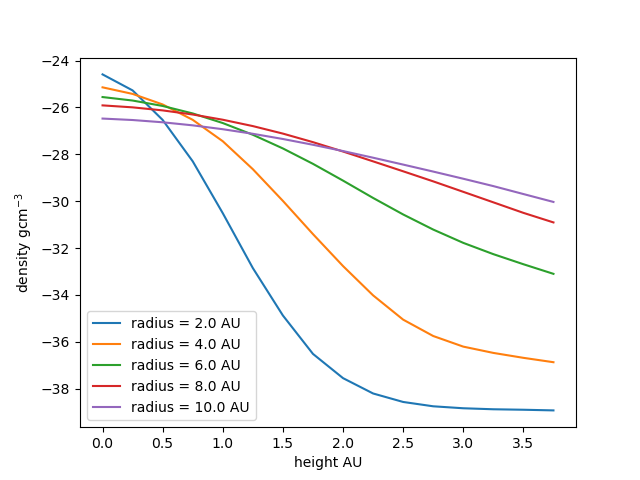

In [60]:
line_label = "radius = {radius:.1f} AU"
plt.figure()
plt.ylabel("density gcm$^{-3}$")
plt.xlabel("height AU")
for d,r in zip(averaged_densities_list,radii):
    plt.plot(height,np.log(d),label=line_label.format(radius=r))
plt.legend()

<IPython.core.display.Javascript object>


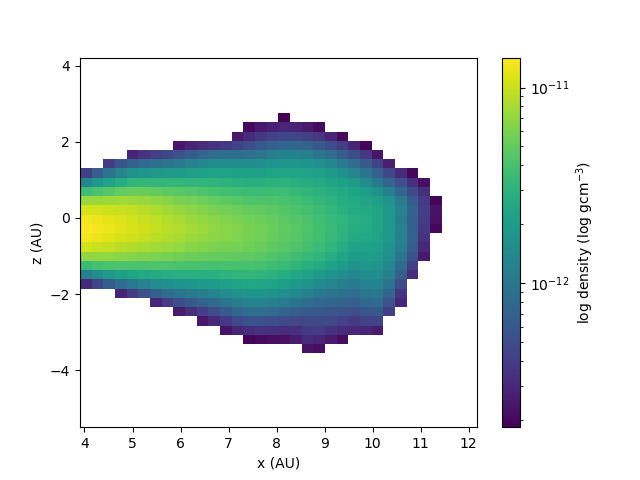

Text(0, 0.5, 'z (AU)')

In [61]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[100:-30,84,60:100,0], cube_au[100:-30,84,60:100,2], (cut_Dens[100:-30,84,60:100]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("log density (log gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


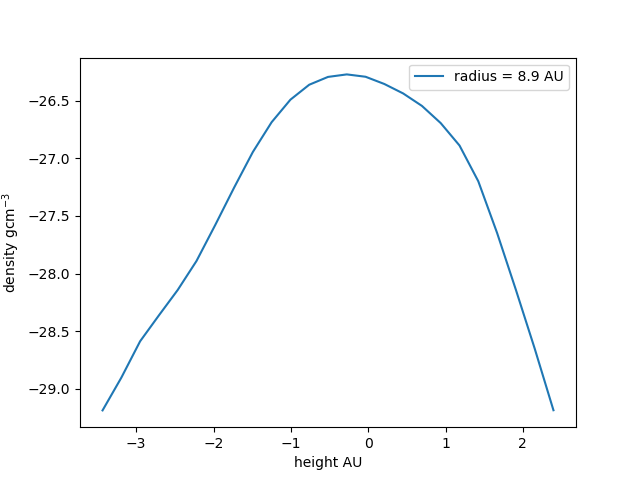

In [62]:
plt.figure()
plt.ylabel("density gcm$^{-3}$")
plt.xlabel("height AU")
plt.plot(cube_au[120,83,60:100,2],np.log(cut_Dens[120,83,60:100]),label=line_label.format(radius=cube_au[120,83,80,0]))
plt.legend()

<IPython.core.display.Javascript object>


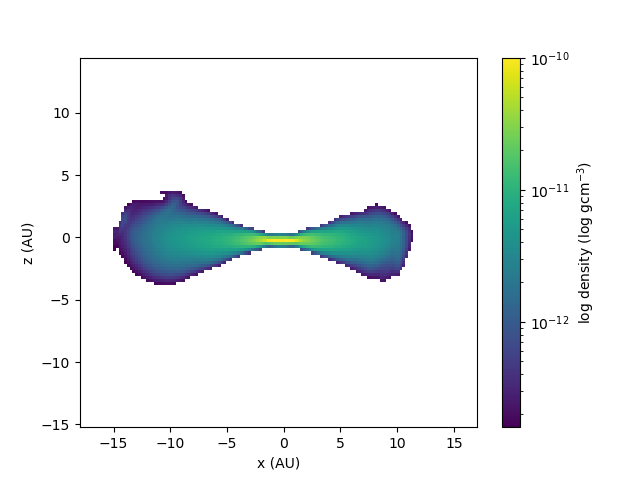

Text(0, 0.5, 'z (AU)')

In [63]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,84,20:-20,0], cube_au[10:-10,84,20:-20,2], (cut_Dens[10:-10,84,20:-20]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("log density (log gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


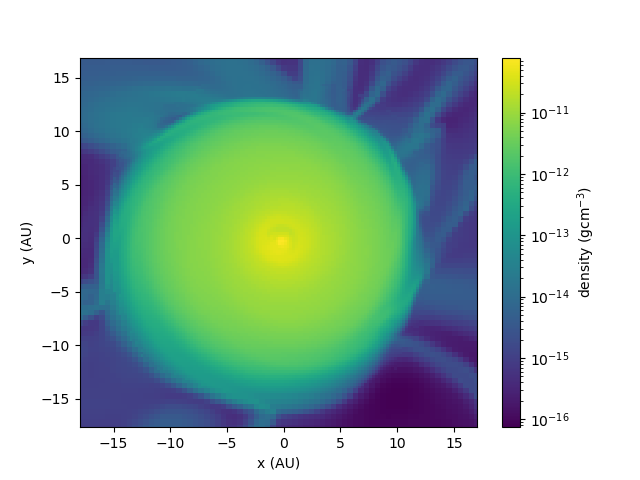

Text(0, 0.5, 'y (AU)')

In [64]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,10:-10,82,0], cube_au[10:-10,10:-10,82,1], (density[10:-10,10:-10,82]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


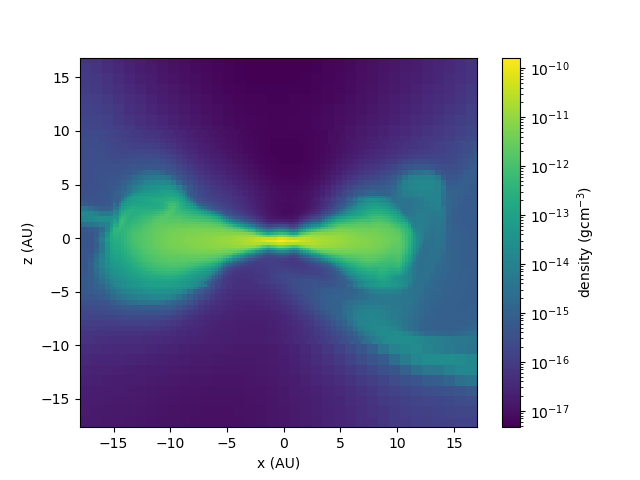

Text(0, 0.5, 'z (AU)')

In [65]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,82,10:-10,0], cube_au[10:-10,82,10:-10,2], (density[10:-10,82,10:-10]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


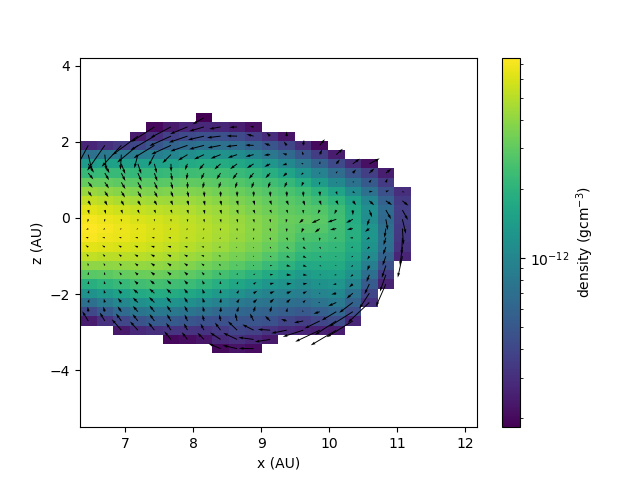

Text(0, 0.5, 'z (AU)')

In [66]:
velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)

fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[110:-30,82,60:100,0], cube_au[110:-30,82,60:100,2],(cut_Dens[110:-30,82,60:100]),norm=colors.LogNorm(), cmap='viridis')
d = ax.quiver(cube_au[110:-30,82,60:100,0], cube_au[110:-30,82,60:100,2],velocity_cut[110:-30,82,60:100,0],velocity_cut[110:-30,82,60:100,2],scale=1.5e6)
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


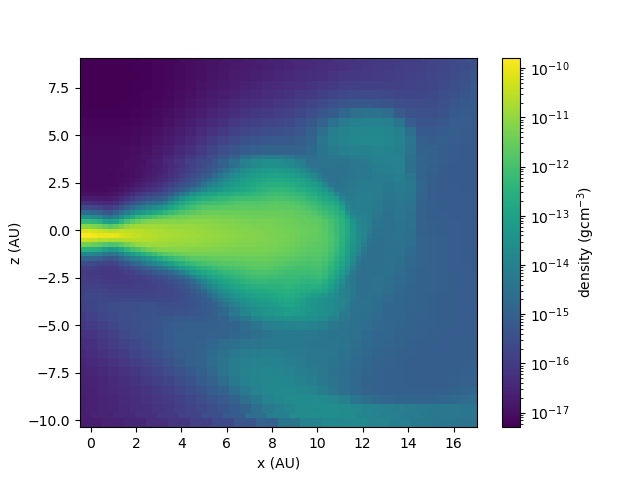

Text(0, 0.5, 'z (AU)')

In [67]:
velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)

fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[82:-10,82,40:120,0], cube_au[82:-10,82,40:120,2],(density[82:-10,82,40:120]),norm=colors.LogNorm(), cmap='viridis')
#d = ax.quiver(cube_au[82:-10,82,40:120,0], cube_au[82:-10,82,40:120,2],velocity[82:-10,82,40:120,0],velocity[82:-10,82,40:120,2])
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

In [68]:
@njit(parallel=True)
def broadcast_dot(vector_array,scalar_array):
    nx,ny,nz,_=vector_array.shape
    return_array=np.zeros_like(vector_array)
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                return_array[i,j,k,0]=vector_array[i,j,k,0]*scalar_array[i,j,k]
                return_array[i,j,k,1]=vector_array[i,j,k,1]*scalar_array[i,j,k]
                return_array[i,j,k,2]=vector_array[i,j,k,2]*scalar_array[i,j,k]
    return return_array

<IPython.core.display.Javascript object>


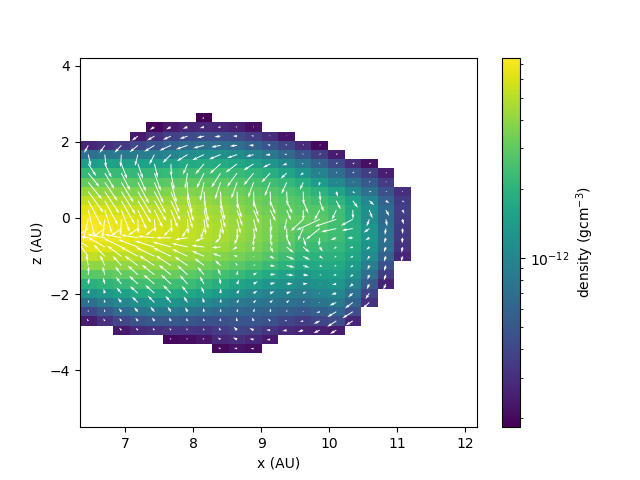

Text(0, 0.5, 'z (AU)')

In [71]:
velocity_cut=disctools.disc_cuts.make_cut_array(velocity,cut_mom_in,angularMom)
mom=broadcast_dot(velocity,density)
mom=disctools.disc_cuts.make_outside_zeros(mom,cut_mom_in,angularMom)
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[110:-30,82,60:100,0], cube_au[110:-30,82,60:100,2],(cut_Dens[110:-30,82,60:100]),norm=colors.LogNorm(), cmap='viridis')
d = ax.quiver(cube_au[110:-30,82,60:100,0], cube_au[110:-30,82,60:100,2],mom[110:-30,82,60:100,0],mom[110:-30,82,60:100,2],scale=1.5e-6,color="white")
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


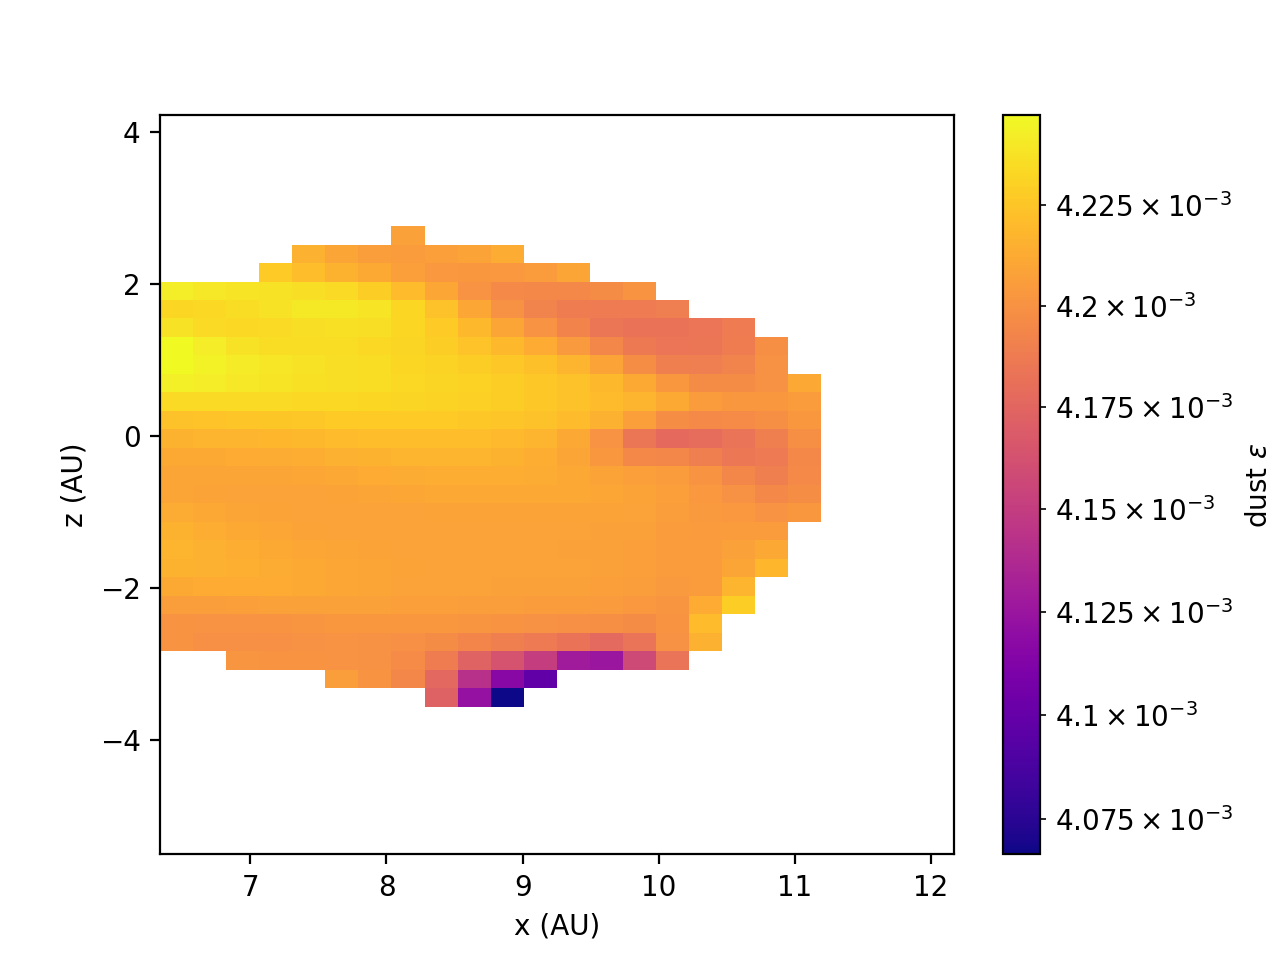

Text(0, 0.5, 'z (AU)')

In [62]:
Eps_sum=disctools.datacube.fill_array_scalar(data["hydro"]["dust_ratio_1"].values,imap)
dustV_Mean=disctools.datacube.fill_array_vector(data["hydro"]["velocity_drift_1"].x.values,data["hydro"]["velocity_drift_1"].y.values,data["hydro"]["velocity_drift_1"].z.values,imap)
for i in range(10,11):
    nameEps="dust_ratio_"+str(i)
    nameV="velocity_drift_"+str(i)
    Eps_sum+=disctools.datacube.fill_array_scalar(data["hydro"][nameEps].values,imap)
    dustV_Mean+=disctools.datacube.fill_array_vector(data["hydro"][nameV].x.values,data["hydro"][nameV].y.values,data["hydro"][nameV].z.values,imap)

dustV_Mean/=10
Eps10=disctools.datacube.fill_array_scalar(data["hydro"]["dust_ratio_10"].values,imap)
dustV10=disctools.datacube.fill_array_vector(data["hydro"]["velocity_drift_10"].x.values,data["hydro"]["velocity_drift_10"].y.values,data["hydro"]["velocity_drift_10"].z.values,imap)
#dustV10+=velocity
Eps10_cut=disctools.disc_cuts.make_cut_array(Eps10,cut_mom_in,angularMom)
dustV10_cut=disctools.disc_cuts.make_cut_array(dustV10,cut_mom_in,angularMom)
EpsSum_cut=disctools.disc_cuts.make_cut_array(Eps_sum,cut_mom_in,angularMom)
dustV_Mean_cut=disctools.disc_cuts.make_cut_array(dustV_Mean,cut_mom_in,angularMom)

fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[110:-30,82,60:100,0], cube_au[110:-30,82,60:100,2],(EpsSum_cut[110:-30,82,60:100]),norm=colors.LogNorm(), cmap='plasma')
#d = ax.quiver(cube_au[81:-30,82,60:100,0], cube_au[81:-30,82,60:100,2],dustV_Mean_cut[81:-30,82,60:100,0],dustV_Mean_cut[81:-30,82,60:100,2])
fig.colorbar(c, ax=ax).set_label("dust $\epsilon$")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

<IPython.core.display.Javascript object>


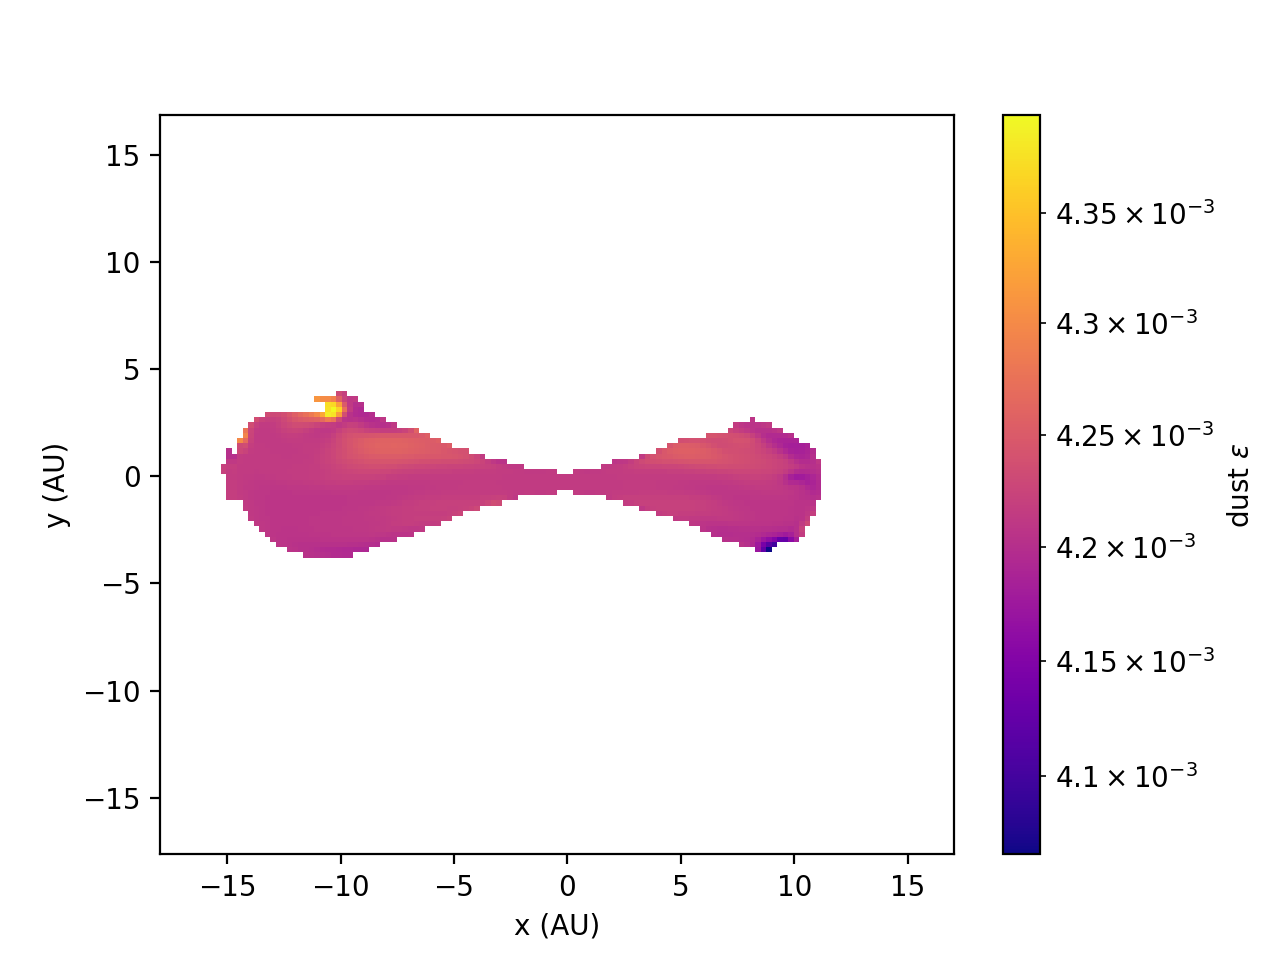

Text(0, 0.5, 'y (AU)')

In [63]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,82,10:-10,0], cube_au[10:-10,82,10:-10,2], ((EpsSum_cut[10:-10,82,10:-10])),norm=colors.LogNorm(), cmap='plasma')
fig.colorbar(c, ax=ax).set_label("dust $\epsilon$")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


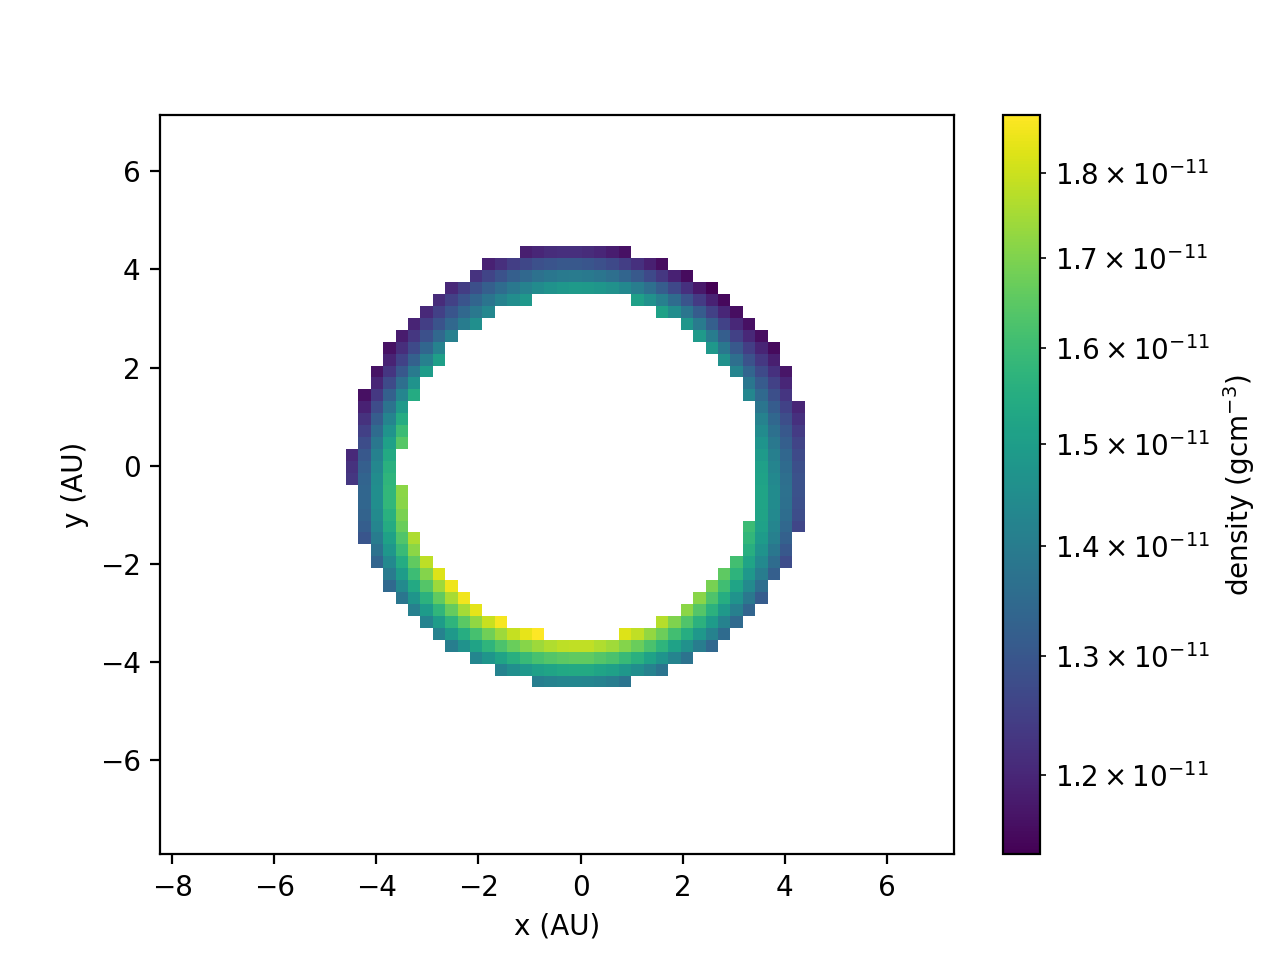

Text(0, 0.5, 'y (AU)')

In [64]:
circle_au=density*disctools.intersections.cells_intersected_circle_int(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,4.0,0.0)
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[50:-50,50:-50,82,0], cube_au[50:-50,50:-50,82,1], (circle_au[50:-50,50:-50,82]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


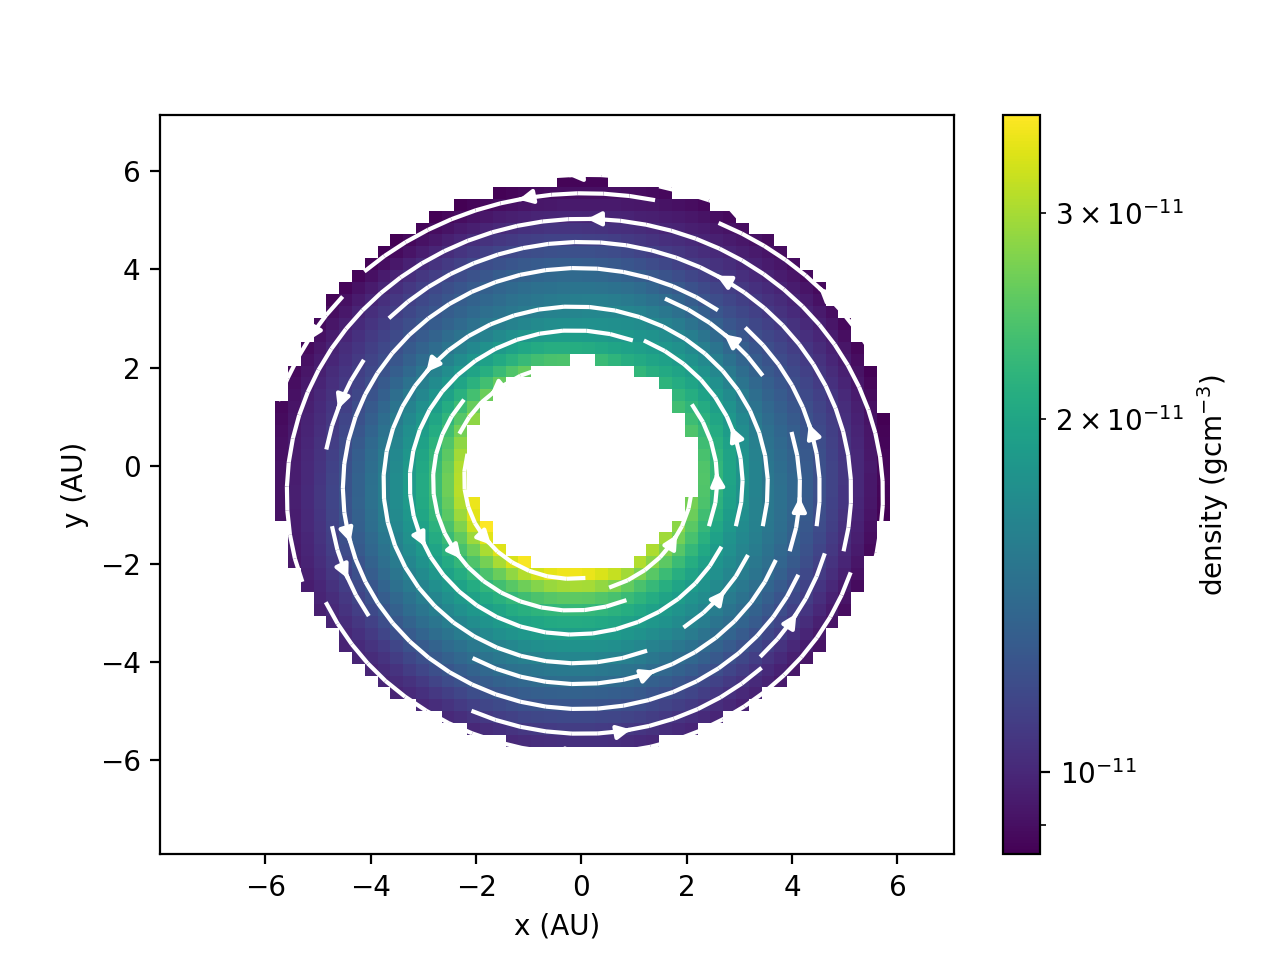

Text(0, 0.5, 'y (AU)')

In [65]:
mask=disctools.intersections.cells_intersected_circle_int(cube_au,15.0*np.min(data["amr"]["dx"].values)*cm_to_au,4.0,0.0)
circle_au=density*mask
circle_v=velocity
circle_v[:,:,:,0]*=mask
circle_v[:,:,:,1]*=mask
circle_v[:,:,:,2]*=mask
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[51:-51,50:-50,82,0], cube_au[51:-51,50:-50,82,1], (circle_au[51:-51,50:-50,82]),norm=colors.LogNorm(), cmap='viridis')
d = ax.streamplot(cube_au[51:-51,50:-50,82,1],cube_au[51:-51,50:-50,82,0],circle_v[51:-51,50:-50,82,1],circle_v[51:-51,50:-50,82,0],color="white")
fig.colorbar(c, ax=ax).set_label("density (gcm$^{-3}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


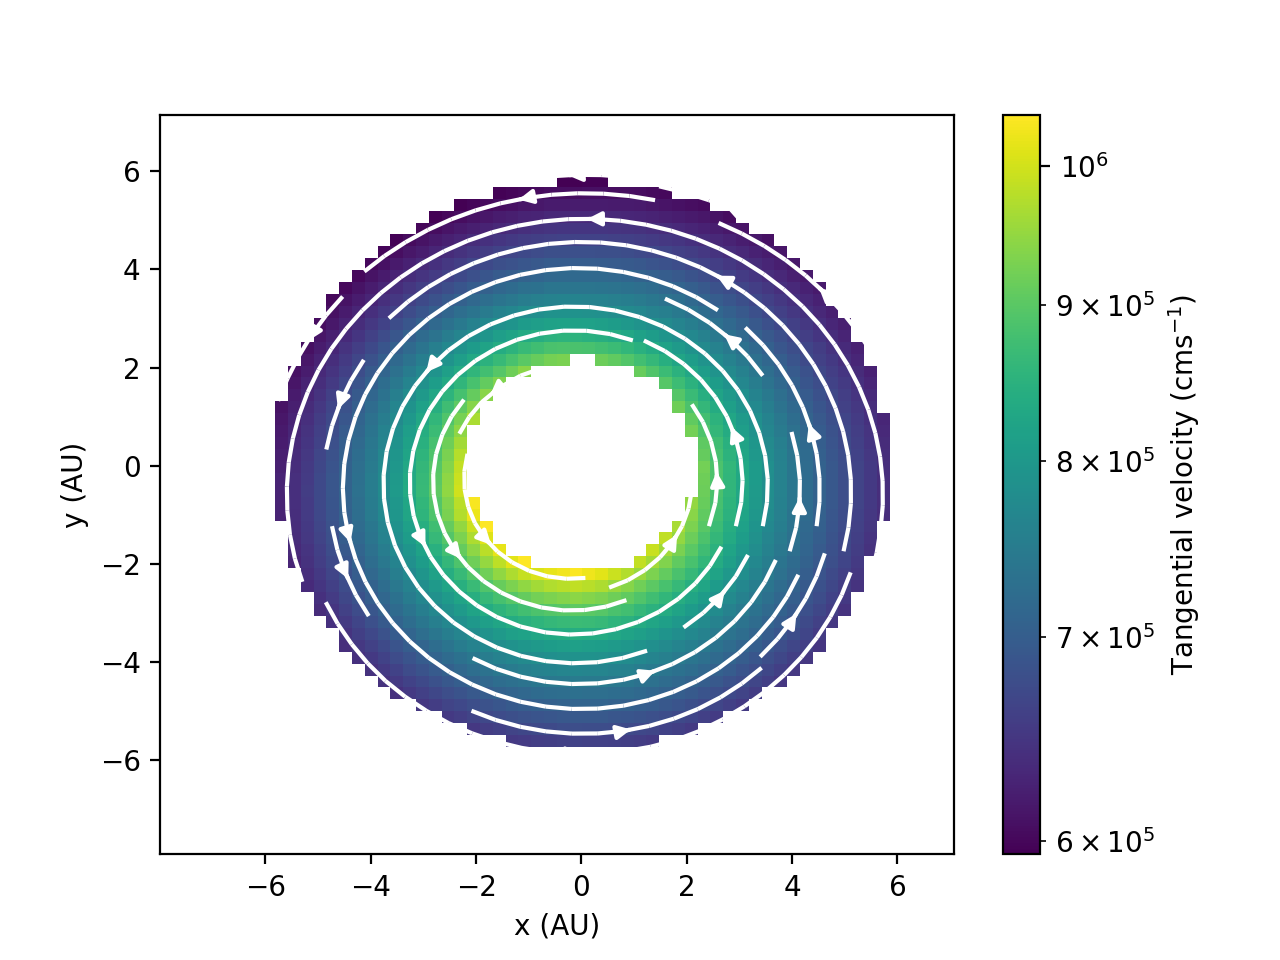

Text(0, 0.5, 'y (AU)')

In [66]:
import matplotlib.colors as colors

circle_v_norm=np.linalg.norm(circle_v[:,:,:,0:2],axis=-1)

fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[51:-51,50:-50,82,0], cube_au[51:-51,50:-50,82,1],(circle_v_norm[51:-51,50:-50,82]),norm=colors.LogNorm(), cmap='viridis')
d = ax.streamplot(cube_au[51:-51,50:-50,82,1],cube_au[51:-51,50:-50,82,0],circle_v[51:-51,50:-50,82,1],circle_v[51:-51,50:-50,82,0],color="white")
fig.colorbar(c, ax=ax).set_label("Tangential velocity (cms$^{-1}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

In [67]:
@njit
def keplerian_velocity_norm(position):
    G=6.6743E-8
    M=0.264*1.989E33
    r=np.linalg.norm(position)
    return r*np.sqrt(G*M/r**3)

@njit(parallel=True)
def get_keplerian_velocity_norms(positions):
    nx,ny,nz,_=positions.shape
    velocities=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                velocities[i,j,k]=keplerian_velocity_norm(positions[i,j,k])
    return velocities

@njit
def keplerian_velocity(position,normal):
    G=6.6743E-8
    M=0.264*1.989E33
    r=np.linalg.norm(position)
    return np.cross(position,normal)*np.sqrt(G*M/r**3)

<IPython.core.display.Javascript object>


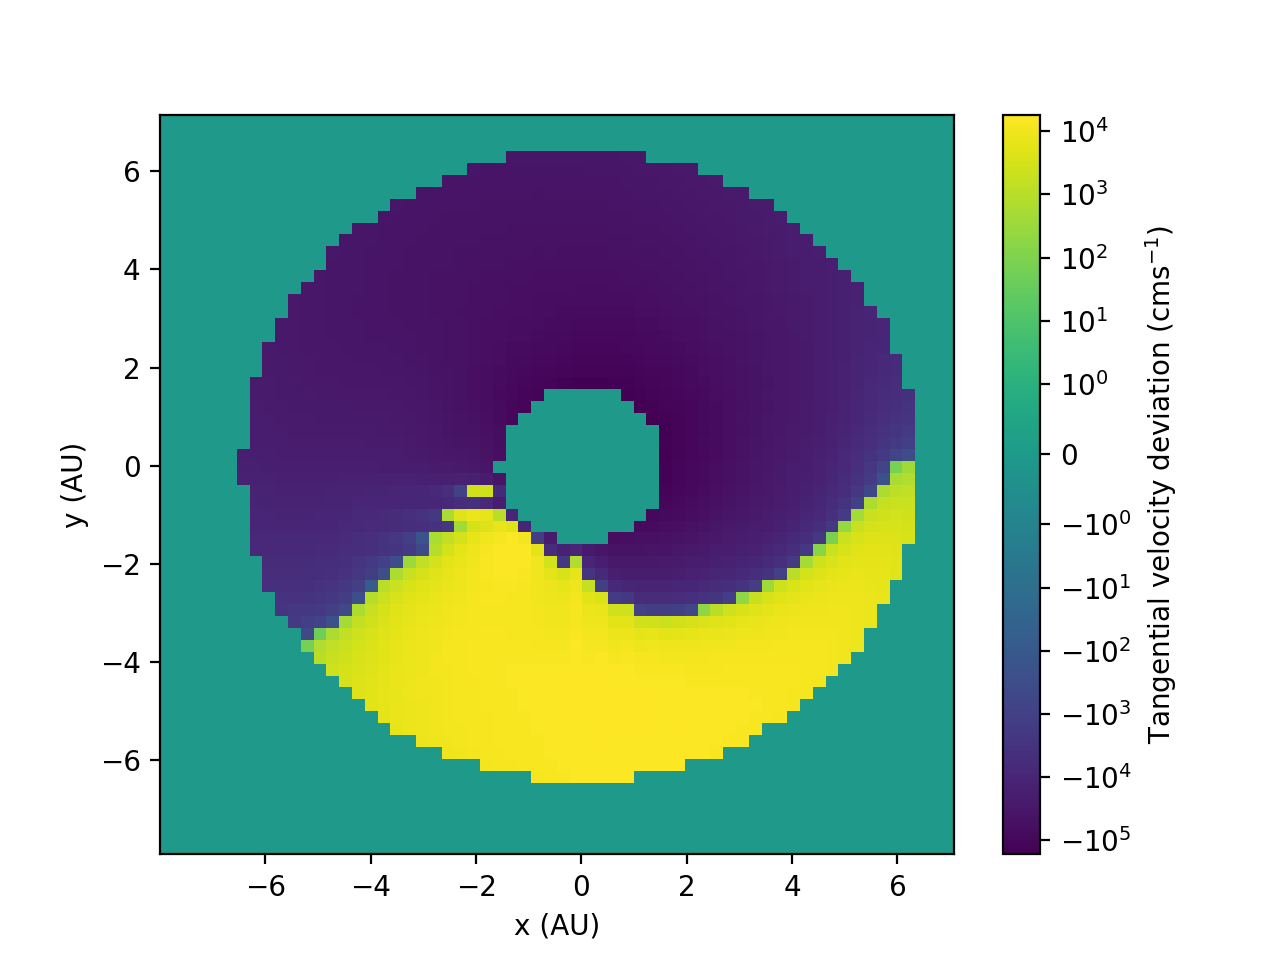

Text(0, 0.5, 'y (AU)')

In [68]:
mask=disctools.intersections.cells_intersected_circle_int(cube_au,20.0*np.min(data["amr"]["dx"].values)*cm_to_au,4.0,0.0)
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity"].x.values,data["hydro"]["velocity"].y.values,data["hydro"]["velocity"].z.values,imap)
circle_v=velocity
circle_v[:,:,:,0]*=mask
circle_v[:,:,:,1]*=mask
circle_v[:,:,:,2]*=mask
circle_v_norm=np.linalg.norm(circle_v[:,:,:,0:2],axis=-1)
kep=get_keplerian_velocity_norms(cube)*mask
circle_v_norm_Kep=circle_v_norm-kep

fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[51:-51,50:-50,82,0], cube_au[51:-51,50:-50,82,1],circle_v_norm_Kep[51:-51,50:-50,82],norm=colors.SymLogNorm(linthresh = 1.0), cmap='viridis')
#d = ax.streamplot(cube_au[51:-51,50:-50,82,1],cube_au[51:-51,50:-50,82,0],circle_v[51:-51,50:-50,82,1],circle_v[51:-51,50:-50,82,0],color="white")
fig.colorbar(c, ax=ax).set_label("Tangential velocity deviation (cms$^{-1}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

In [141]:
mass=data["sink"]["M"].values[0]
mass=mass*1.989e+33

In [142]:
@njit
def toomre_Q(cs,surfaceDensity,position,mass):
    G=6.6743E-8
    Omega=np.sqrt(G*mass/(np.linalg.norm(position)**3))
    return cs*Omega/(np.pi*G*surfaceDensity)

@njit
def omega(position,mass):
    G=6.6743E-8
    return np.sqrt(G*mass/(np.linalg.norm(position)**3))

@njit
def toomre_Q_array(cs,surfaceDensity,position,mass):
    Q=np.zeros_like(surfaceDensity)
    nx,ny=cs.shape
    for i in prange(nx):
        for j in range(ny):
            Q[i,j]=toomre_Q(cs[i,j],surfaceDensity[i,j],position[i,j],mass)
    return Q

@njit
def omega_array(surfaceDensity,position,mass):
    Q=np.zeros_like(surfaceDensity)
    nx,ny=Q.shape
    for i in prange(nx):
        for j in range(ny):
            Q[i,j]=omega(position[i,j],mass)
    return Q

<IPython.core.display.Javascript object>


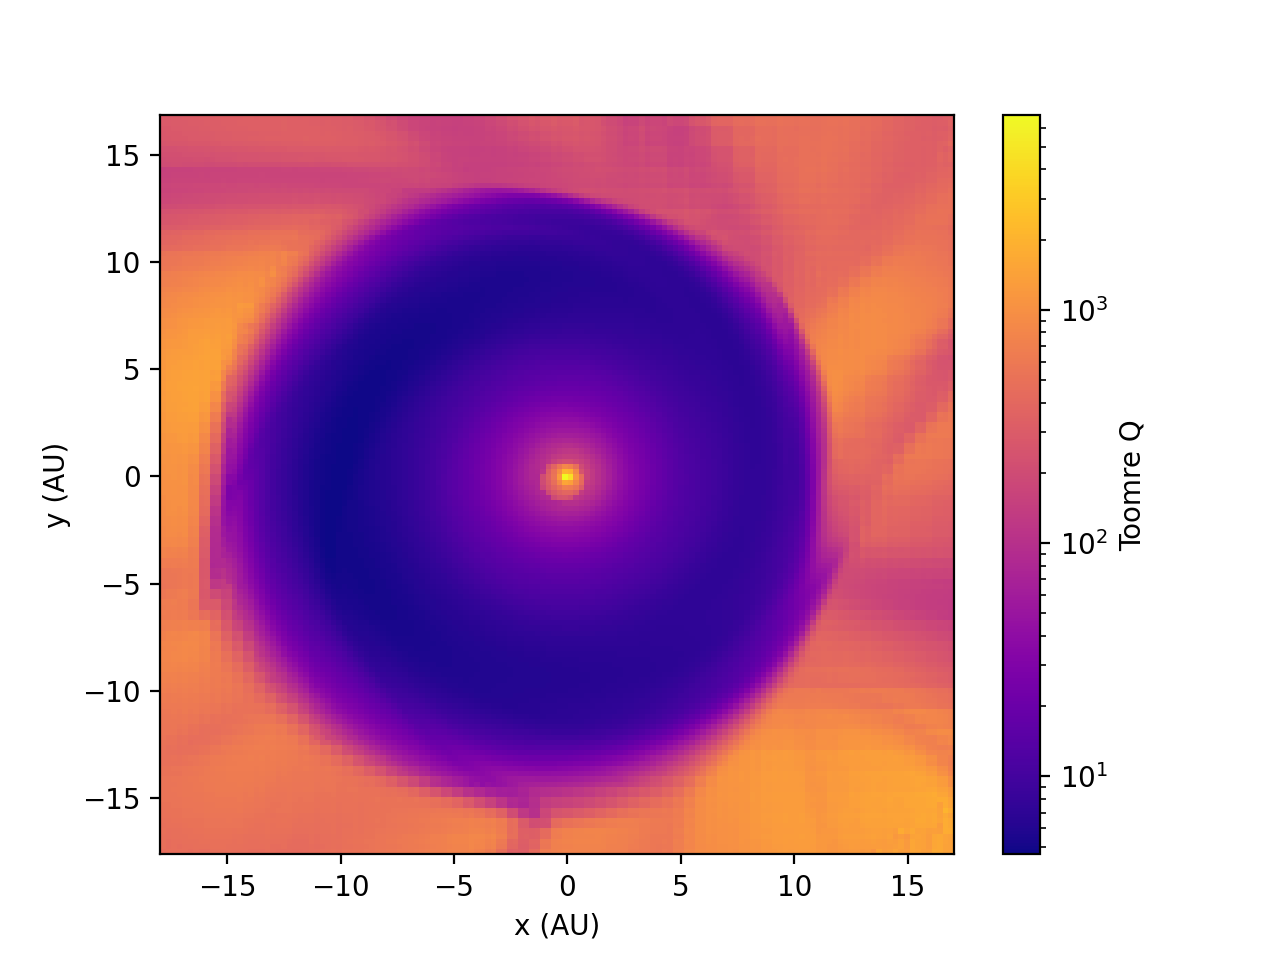

Text(0, 0.5, 'y (AU)')

In [147]:
dx=data["amr"]["dx"].values.min()
surface_density=np.sum(density*dx,axis=-1)
toom=toomre_Q_array(cs[:,:,82],surface_density,cube[:,:,82],mass)
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,10:-10,82,0], cube_au[10:-10,10:-10,82,1], (toom[10:-10,10:-10]),norm=colors.LogNorm(), cmap='plasma')
fig.colorbar(c, ax=ax).set_label("Toomre Q")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

In [71]:
imp.reload(disctools.disc_analysis)

<module 'disctools.disc_analysis' from '/Users/fra/opt/anaconda3/lib/python3.9/site-packages/disctools/disc_analysis.py'>

In [76]:
disctools.disc_analysis.eccentricity_vector(0.264*1.989E33,cube[100,100,50,:],velocity[100,100,50,:])

array([-0.41092169, -0.44352735,  0.79650916])

<IPython.core.display.Javascript object>


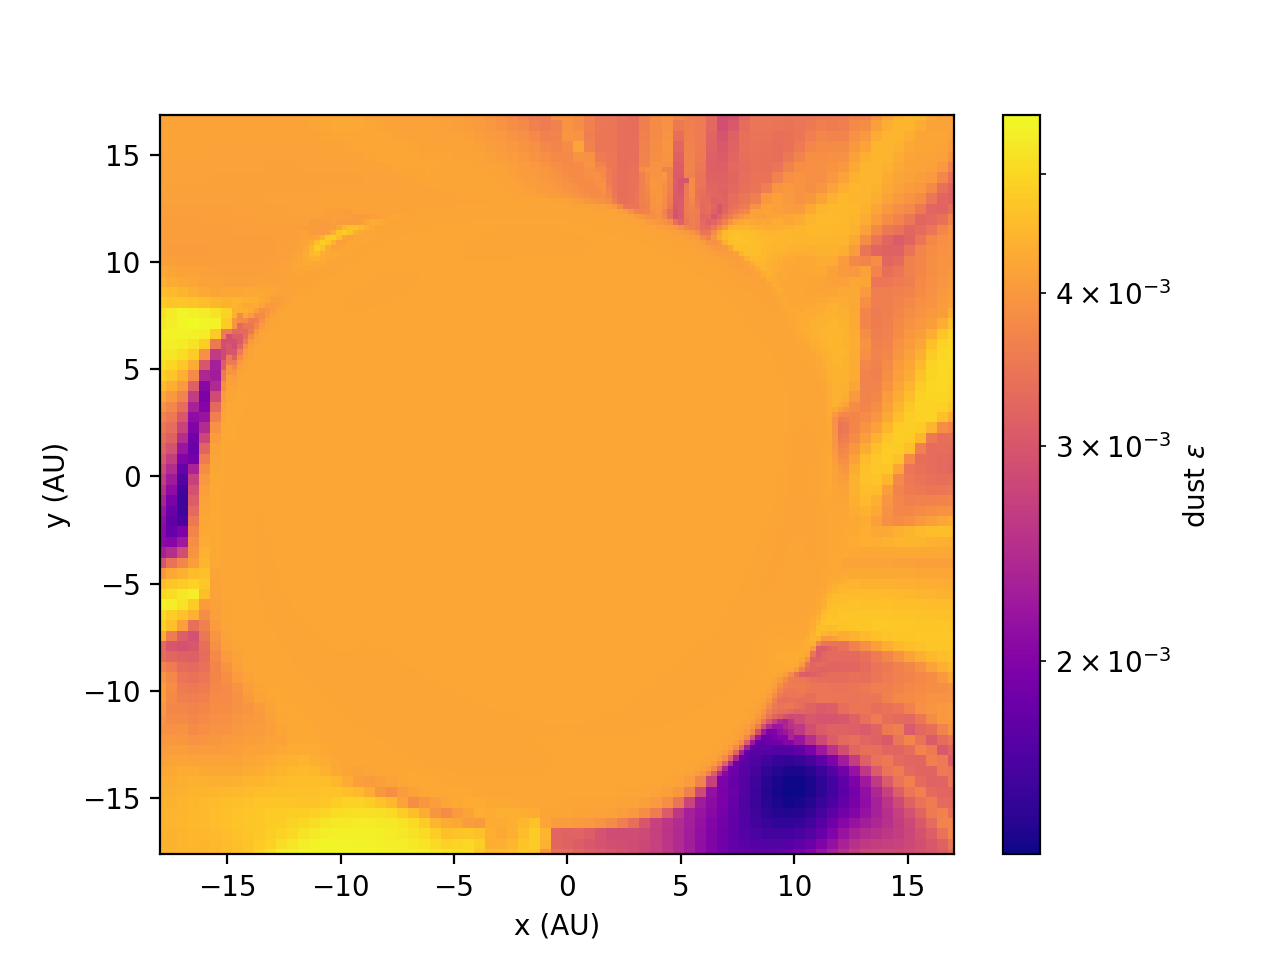

Text(0, 0.5, 'y (AU)')

In [77]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,10:-10,82,0], cube_au[10:-10,10:-10,82,1], (Eps_sum[10:-10,10:-10,82]),norm=colors.LogNorm(), cmap='plasma')
fig.colorbar(c, ax=ax).set_label("dust $\epsilon$")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


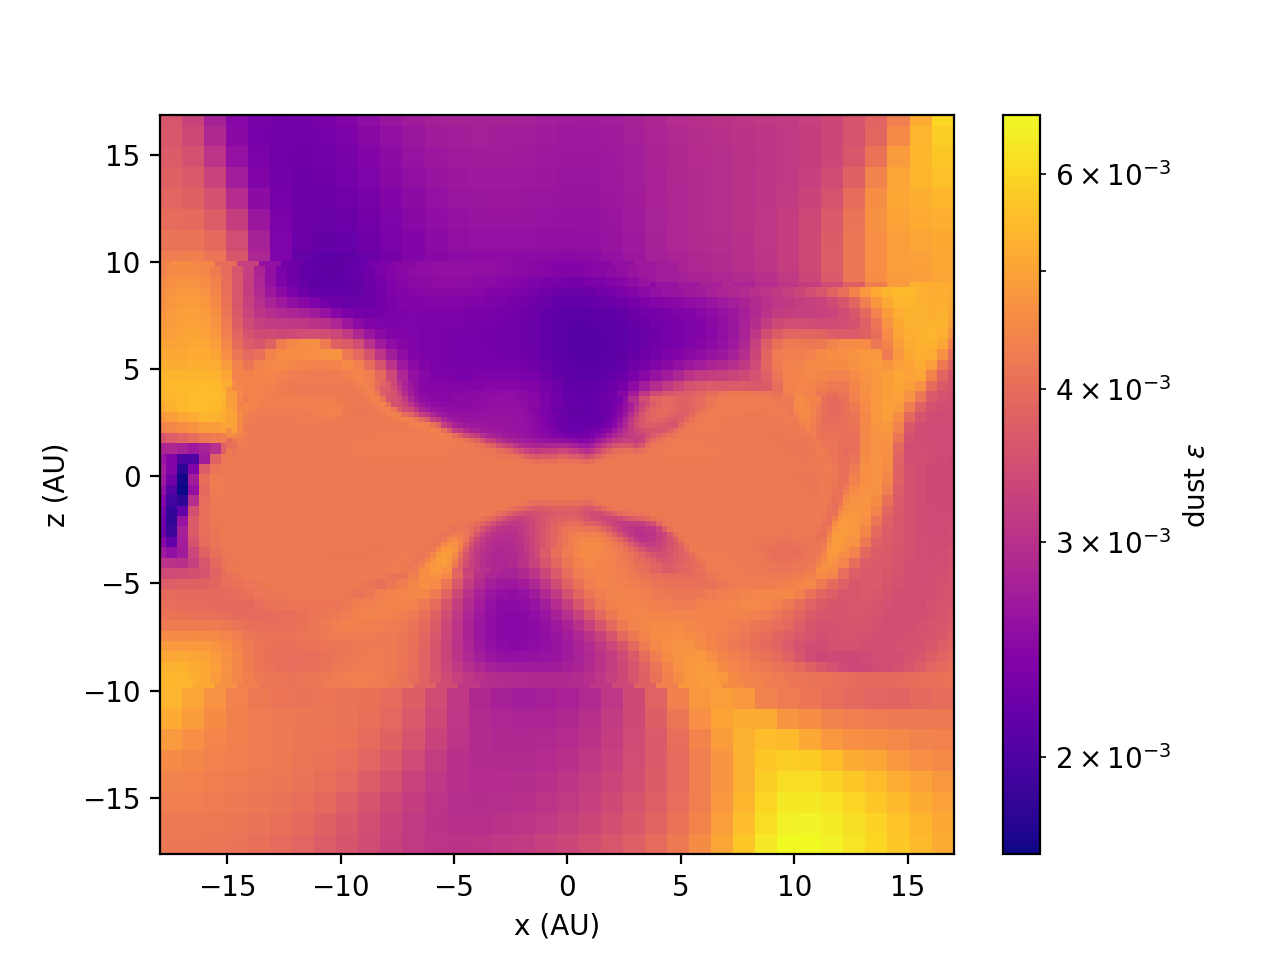

Text(0, 0.5, 'z (AU)')

In [78]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,82,10:-10,0], cube_au[10:-10,82,10:-10,2], (Eps_sum[10:-10,82,10:-10]),norm=colors.LogNorm(), cmap='plasma')
fig.colorbar(c, ax=ax).set_label("dust $\epsilon$")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

In [79]:
cube[circle_1au_i].shape

(4160, 3)

In [80]:
data["hydro"]["velocity_mod"]=data["hydro"]["velocity"]-data["sink"]["v"]
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity_mod"].x.values,data["hydro"]["velocity_mod"].y.values,data["hydro"]["velocity_mod"].z.values,imap)
radii=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5]
v_list=[]
for rad in radii:
    averaged_densities=np.zeros(16)
    circle_1au_i=disctools.intersections.cells_intersected_circle(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,rad,0.0)
    v_rad=[-1*np.dot(vel,pos)/np.linalg.norm(pos) for vel,pos in zip(velocity[circle_1au_i],cube[circle_1au_i])]
    #print(v_rad)
    v_list.append(np.mean(v_rad))

In [81]:
data["hydro"]["velocity_mod"]=data["hydro"]["velocity"]-data["sink"]["v"]
velocity=disctools.datacube.fill_array_vector(data["hydro"]["velocity_mod"].x.values,data["hydro"]["velocity_mod"].y.values,data["hydro"]["velocity_mod"].z.values,imap)
radii=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5]
v_list=[]
for rad in radii:
    averaged_densities=np.zeros(16)
    circle_1au_i=disctools.intersections.cells_intersected_circle(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,rad,0.0)
    v_rad=[-1*dens*np.dot(vel,pos)/np.linalg.norm(pos) for vel,dens,pos in zip(velocity[circle_1au_i],density[circle_1au_i],cube[circle_1au_i])]
    #print(v_rad)
    v_list.append(np.mean(v_rad))

<IPython.core.display.Javascript object>


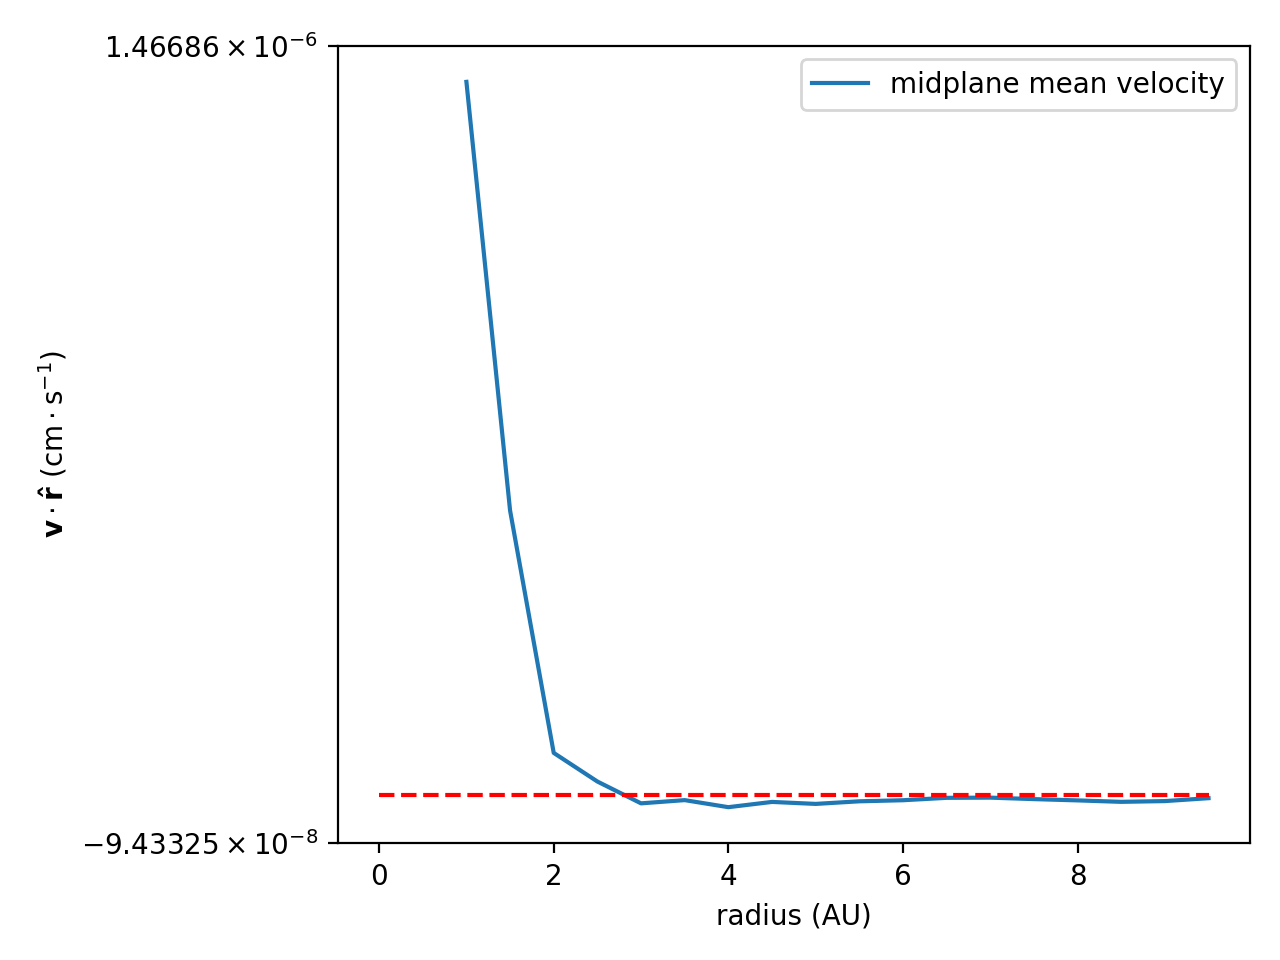

In [82]:
plt.figure()
plt.plot(radii,v_list,label="midplane mean velocity")
plt.hlines(0,xmin=0,xmax=radii[-1],linestyle="dashed", color="red")
plt.xlabel("radius (AU)")
plt.ylabel("$\mathbf{v}\cdot\mathbf{\hat{r}}$ ($\mathrm{cm\cdot s}^{-1}$)")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()

In [112]:
#data["hydro"]["velocity_mod"]=data["hydro"]["velocity"]-data["sink"]["v"]
Temp=disctools.datacube.fill_array_scalar(data["hydro"]["temperature"].values,imap)
radii=[1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5]
t_list=[]
for rad in radii:
    averaged_densities=np.zeros(16)
    circle_1au_i=disctools.intersections.cells_intersected_circle(cube_au,4.0*np.min(data["amr"]["dx"].values)*cm_to_au,rad,0.0)
    T=[t for t in Temp[circle_1au_i]]
    #print(v_rad)
    t_list.append(np.mean(T))

/var/folders/lr/w2rb22ks5v78l_gp4s5dz17h0000gn/T/ipykernel_43387/3730028702.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


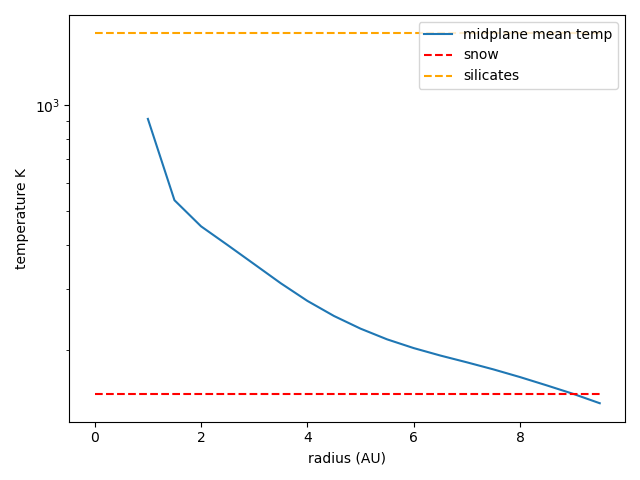

In [113]:
plt.figure()
plt.plot(radii,t_list,label="midplane mean temp")
plt.hlines(150,xmin=0,xmax=radii[-1],linestyle="dashed", color="red",label="snow")
plt.hlines(1600,xmin=0,xmax=radii[-1],linestyle="dashed", color="orange",label="silicates")
plt.xlabel("radius (AU)")
plt.ylabel("temperature K")
plt.yscale('log')
plt.legend()
plt.tight_layout()

In [83]:
@njit
def get_rad_v(velocity,position):
    nx,ny,nz,_=position.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=-velocity[i,j,k,:]@position[i,j,k,:]/np.linalg.norm(position[i,j,k,:])
    return rv

In [142]:
@njit
def get_e_loc(L,a):
    nx,ny,nz,_=L.shape
    rv=np.zeros((nx,ny,nz))
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                rv[i,j,k]=np.sqrt(1.0-L[i,j,k]@L[i,j,k]/(0.264*1.989E33*a[i,j,k]))
    return rv

In [143]:
ee=get_e_loc(angularMom,a_grid)

<IPython.core.display.Javascript object>


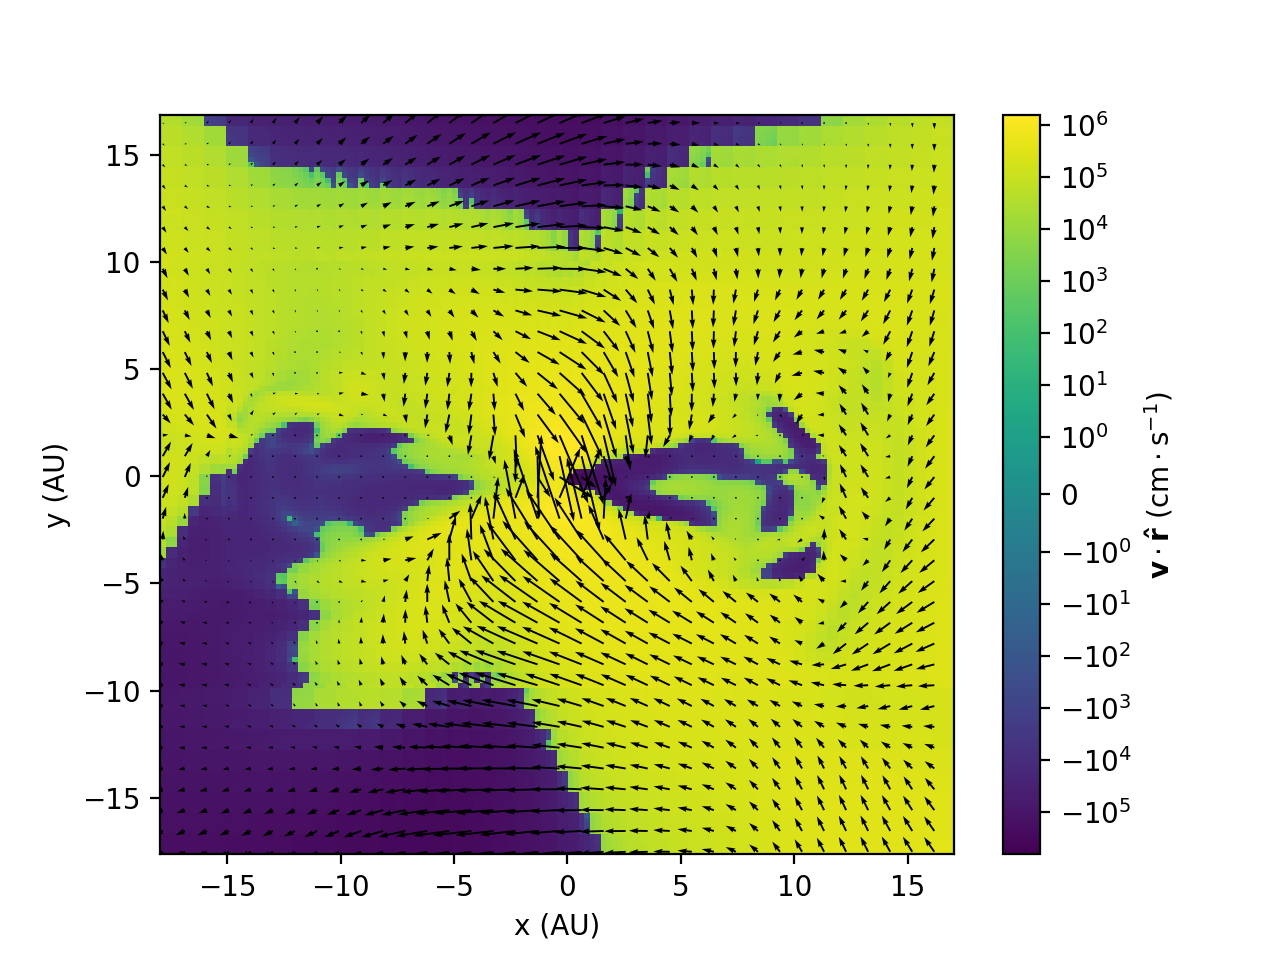

Text(0, 0.5, 'y (AU)')

In [93]:
density=0.25
scale=int(np.ceil(1/density))
rv=get_rad_v(velocity,cube)
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[20:-20,82,20:-20,0], cube_au[20:-20,82,20:-20,2], (rv[20:-20,82,20:-20]),norm=colors.SymLogNorm(linthresh = 1.0), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("$\mathbf{v}\cdot\mathbf{\hat{r}}$ ($\mathrm{cm\cdot s}^{-1}$)")
d = ax.quiver(cube_au[20:-20:scale,82,20:-20:scale,0], cube_au[20:-20:scale,82,20:-20:scale,2],velocity[20:-20:scale,82,20:-20:scale,0],velocity[20:-20:scale,82,10:-10:scale,2],scale=1.5e7)
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

<IPython.core.display.Javascript object>


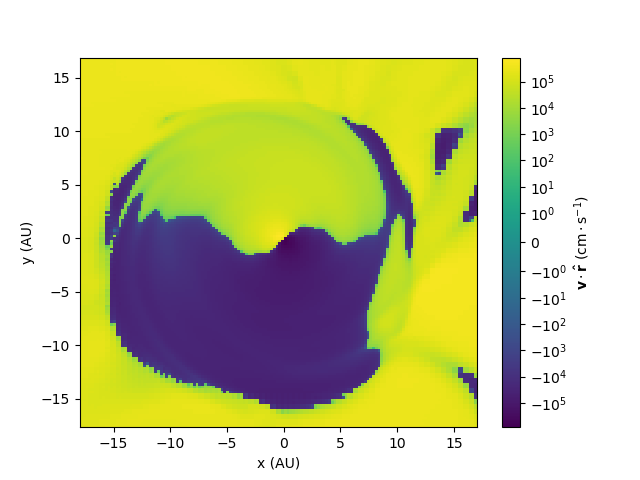

Text(0, 0.5, 'y (AU)')

In [116]:
rv=get_rad_v(velocity,cube)
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,10:-10,82,0], cube_au[10:-10,10:-10,82,1], (rv[10:-10,10:-10,82]),norm=colors.SymLogNorm(linthresh = 1.0), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("$\mathbf{v}\cdot\mathbf{\hat{r}}$ ($\mathrm{cm\cdot s}^{-1}$)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,10:-10,82,0], cube_au[10:-10,10:-10,82,1], (Temp[10:-10,10:-10,82]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("T (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("y (AU)")

In [ ]:
fig, ax = plt.subplots()
c = ax.pcolormesh(cube_au[10:-10,82,10:-10,0], cube_au[10:-10,82,10:-10,2], (Temp[10:-10,82,10:-10]),norm=colors.LogNorm(), cmap='viridis')
fig.colorbar(c, ax=ax).set_label("T (K)")
ax.set_xlabel("x (AU)")
ax.set_ylabel("z (AU)")

In [88]:
radii=np.linspace(1.0,12,100)
rv_list=[]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,cube_au,velocity,density)
for a in radii:
    averaged_densities=np.zeros(16)
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    rv=np.sum([-1*dens*np.dot(vel,pos)/np.linalg.norm(pos) for vel,dens,pos in zip(velocity[a_mask],density[a_mask],cube[a_mask])])
    rv_list.append(rv)

[0.00014658196560347734, 7.414903631197239e-05, 7.241629621482763e-05, 5.980738071544514e-05, 2.445251931983345e-05, 2.622920715715071e-05, 4.803010680081202e-05, 4.204702662429539e-05, 3.3125218951587606e-05, 4.285781312252374e-05, 4.530971941357381e-05, 3.738369541875064e-05, 2.836013071950887e-05, 3.2444810637797736e-05, 9.82135260300519e-06, 8.891946787448812e-06, 2.0901207002209172e-05, 2.946873693699157e-05, 3.626523593090576e-05, 4.39262991761852e-05, 5.96947623401937e-05, 5.8121196709045186e-05, 6.827899241937453e-05, 7.725681790723002e-05, 7.532432254895941e-05, 6.941584075183766e-05, 7.132338578623093e-05, 7.238021471792036e-05, 6.770247491933825e-05, 6.967437437865484e-05, 6.785916575586268e-05, 5.604283108567703e-05, 4.8501825607142956e-05, 4.658739881325711e-05, 4.479524153655025e-05, 4.127647902198332e-05, 4.576792374070741e-05, 4.9722915996285423e-05, 4.9494538684645234e-05, 5.15359994551883e-05, 5.7802310299917176e-05, 6.441436987609604e-05, 7.081030636992167e-05, 7.741

<IPython.core.display.Javascript object>


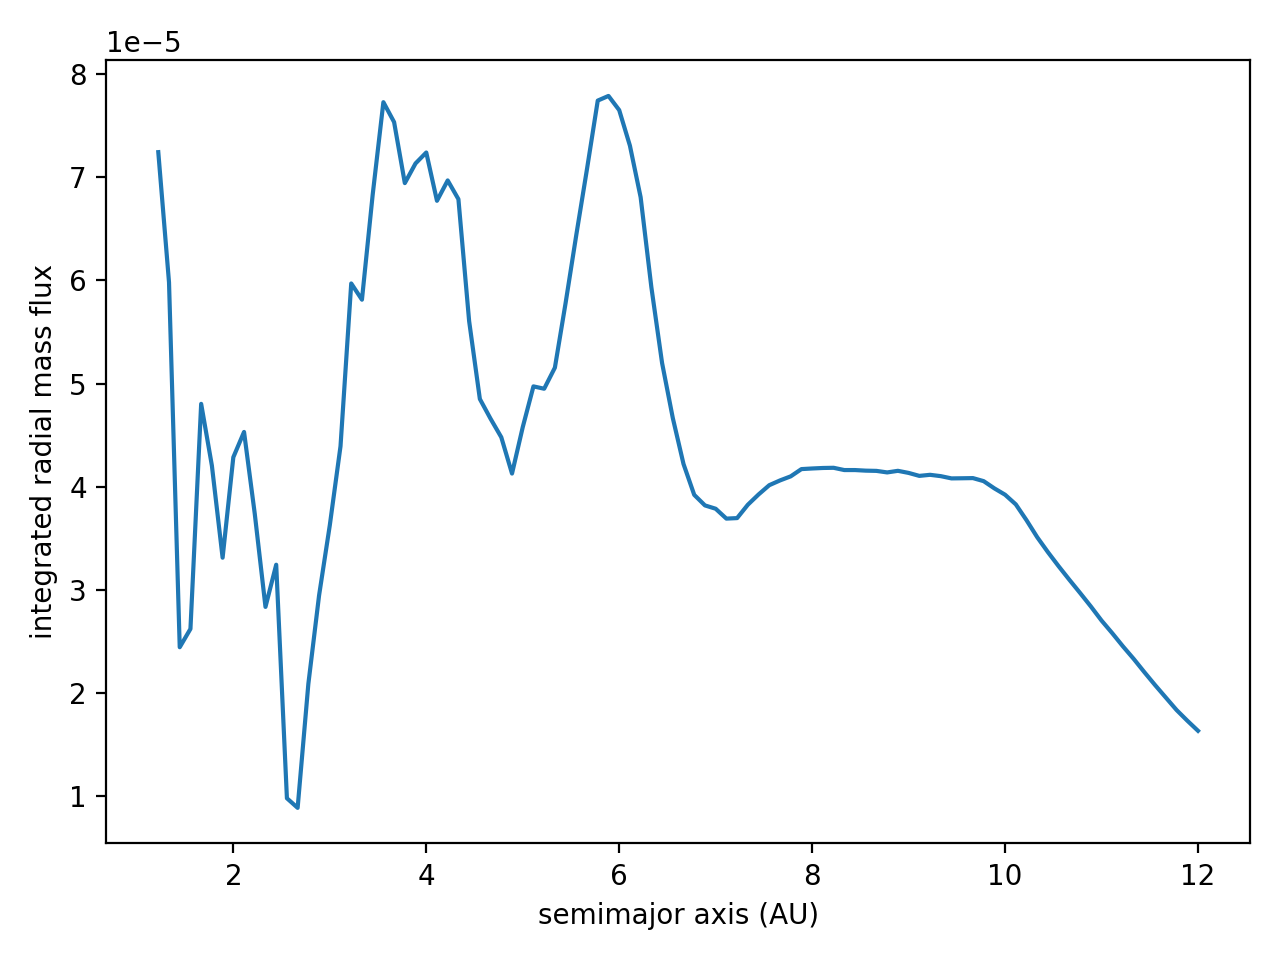

In [92]:
plt.figure()
plt.plot(radii[2:],rv_list[2:])
plt.xlabel("semimajor axis (AU)")
plt.ylabel("integrated radial mass flux")
plt.tight_layout()

In [95]:
radii=np.linspace(1.0,12,100)
rv_list=[]
v_midplane=velocity[:,:,82,:]
x_midplane=cube_au[:,:,82,:]
dens_midplane=density[:,:,82]
a_grid=disctools.disc_analysis.get_a_on_grid(0.264*1.989E33,x_midplane,v_midplane,dens_midplane)

for a in radii:
    averaged_densities=np.zeros(16)
    a_mask=np.where(np.abs(a_grid-a)<0.1,True,False)
    rv=np.sum([-1*dens*np.dot(vel,pos)/np.linalg.norm(pos) for vel,dens,pos in zip(v_midplane[a_mask],dens_midplane[a_mask],x_midplane[a_mask])])
    rv_list.append(rv)

TypeError: 'float' object is not subscriptable